In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e4/sample_submission.csv
/kaggle/input/playground-series-s4e4/train.csv
/kaggle/input/playground-series-s4e4/test.csv


In [2]:
import re
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet,SGDRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
import lightgbm as lgbm
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import itertools
from tqdm import tqdm
from catboost import Pool, CatBoostRegressor

In [3]:
!pip install optuna

In [4]:
import optuna

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
def tfmodel(model_0):
    model_1 = TransformedTargetRegressor(model_0\
                                        , func = np.log1p\
                                        , inverse_func = np.expm1)
    return model_1

In [7]:
def RMSLE(arr_y,arr_p):
    score = np.sqrt(mean_squared_log_error(arr_y,arr_p))
    return score

In [8]:
def RMSE(arr_y,arr_p):
    score = mean_squared_error(arr_y,arr_p,squared=True)
    return score

In [9]:
class ClsData00():
    def __init__(self,seed=0):

        df_train_org = pd.read_csv(os.path.join(dirname,'train.csv'))
        df_test_org = pd.read_csv(os.path.join(dirname,'test.csv'))
        df_sample = pd.read_csv(os.path.join(dirname,'sample_submission.csv'))

        df_cve_X = df_train_org.set_index('id').drop(['Rings'],axis='columns')
        df_cve_y = df_train_org.set_index('id')['Rings']
        df_t_X = df_test_org.set_index('id')
        
        def func_(df_0):
            lst_cols = df_0.columns.to_list()
            lst_cols = [re.sub(' ','_',s) for s in lst_cols]
            lst_cols = [re.sub(r'\.','_',s) for s in lst_cols]
            df_0.columns = lst_cols
            return df_0
        df_cve_X = func_(df_cve_X)
        df_t_X = func_(df_t_X)
        
        def func_(df_0):
            df_1 = pd.get_dummies(df_0['Sex'],dtype=int,prefix='is')
            df_2 = df_0.drop(['Sex'],axis='columns')
            sclr = StandardScaler()
            arr_3 = sclr.fit_transform(df_2)
            df_3 = pd.DataFrame(arr_3, index=df_2.index, columns=df_2.columns)
            df_4= pd.concat([df_1,df_3],axis='columns')
            return df_4
        df_cve_X = func_(df_cve_X)
        df_t_X = func_(df_t_X)
        
        self.df_cve_X = df_cve_X
        self.df_cve_y = df_cve_y
        self.df_t_X = df_t_X
        df_cv_X,df_e_X,df_cv_y,df_e_y = train_test_split(\
                                                         df_cve_X,df_cve_y\
                                                        , test_size=0.2\
                                                        , shuffle=True\
                                                        , stratify=df_cve_y\
                                                        , random_state=seed\
                                                        )
        self.df_cv_X = df_cv_X
        self.df_cv_y = df_cv_y
        self.df_e_X = df_e_X
        self.df_e_y = df_e_y
    def undersampling(self,seed=0):
        df_cv_X = self.df_cv_X
        df_cv_y = self.df_cv_y
        rus = RandomUnderSampler(random_state=seed)
        df_cv_X, df_cv_y = rus.fit_resample(df_cv_X,df_cv_y)
        self.df_cv_X = df_cv_X
        self.df_cv_y = df_cv_y
        
        
clsData = ClsData00(seed=0)

In [10]:
class ClsModelHistGradientBoostingRegressor():
    def __init__(self,clsData):
        df_cve_X = clsData.df_cve_X
        df_cve_y = clsData.df_cve_y
        df_t_X = clsData.df_t_X
        df_cv_X = clsData.df_cv_X
        df_cv_y = clsData.df_cv_y
        df_e_X = clsData.df_e_X
        df_e_y = clsData.df_e_y
        
        self.df_cve_X = df_cve_X
        self.df_cve_y = df_cve_y
        self.df_t_X = df_t_X
        self.df_cv_X = df_cv_X
        self.df_cv_y = df_cv_y
        self.df_e_X = df_e_X
        self.df_e_y = df_e_y
    def Params(self):
        params = {'loss':'squared_error'\
                 , 'quantile':0.5\
                 , 'learning_rate':0.1\
                 , 'max_iter':100\
                 , 'max_leaf_nodes':31\
                 , 'max_depth':2\
                 , 'min_samples_leaf':20\
                 , 'l2_regularization':0\
#                  , 'max_features':1.0\
                 , 'max_bins':255\
                 , 'categorical_features':['is_F','is_I','is_M']\
                 , 'random_state':17\
                 }
        self.params = params
    def model(self,params={}):
        model_0 = HistGradientBoostingRegressor(**params)
        model = tfmodel(model_0)
        return model
    def objective(self,trial):
        params = self.params
        params['loss'] = trial.suggest_categorical('loss',['squared_error','absolute_error','poisson','quantile'])
        params['quantile'] = trial.suggest_float('quantile',0,1)
        params['learning_rate'] = trial.suggest_float('learning_rate',1e-2,1e-0)
        params['max_iter'] = trial.suggest_int('max_iter', 50,150)
        params['max_leaf_nodes'] = trial.suggest_int('max_leaf_nodes',16,63)
        params['max_depth'] = trial.suggest_int('max_depth',3,13)
        params['min_samples_leaf'] = trial.suggest_int('min_samples_leaf',10,30)
        params['l2_regularization'] = trial.suggest_float('l2_regularization',0,0.5)
#         params['max_features'] = trial.suggest_float('max_features',0.1,1.0)
        params['max_bins'] = trial.suggest_int('max_bins',125,255)
        
        df_cve_X = self.df_cve_X
        df_cve_y = self.df_cve_y
        
        model = self.model(params)
        
        model.fit(df_cve_X,df_cve_y)
        pred_y = model.predict(df_cve_X)
        pred_y = np.where(pred_y<0.0,0.0,pred_y)
        pred_y = np.where(pred_y>30.0,30.0,pred_y)
        score = RMSLE(df_cve_y.values, pred_y)
#         score = RMSE(df_cve_y.values, pred_y)
        return score
    def optuna(self, n_trials=3, plot_history=False):
        self.Params()
        sampler = optuna.samplers.TPESampler(seed=17)
        optuna.logging.set_verbosity(optuna.logging.CRITICAL)
        study = optuna.create_study(sampler=sampler,direction='minimize')
        study.optimize(self.objective, n_trials=n_trials)
        self.study = study
        params = self.params
        self.params = params
#         print('optuna_best_score_e: ',study.best_value)
        if plot_history==True:
            optuna.visualization.matplotlib.plot_optimization_history(study)
#             fig.show()
            plt.tight_layout()
            plt.show()
    def train_cv(self,n_splits=5,n_repeats=10,seed=0,plot=False):
        df_cve_X = self.df_cve_X
        df_cve_y = self.df_cve_y
        params = self.params
        
        lst_models = []
        lst_score_v = []
        rskf = RepeatedStratifiedKFold(n_splits=n_splits\
                                       ,n_repeats=n_repeats\
                                      , random_state=seed)
        df_p = pd.DataFrame()
        for idx_c,idx_v in tqdm(rskf.split(df_cve_X,df_cve_y)):
            df_c_X = df_cve_X.iloc[idx_c]
            df_c_y = df_cve_y.iloc[idx_c]
            df_v_X = df_cve_X.iloc[idx_v]
            df_v_y = df_cve_y.iloc[idx_v]
            model = self.model(params)
            model.fit(df_c_X,df_c_y)
            pred = model.predict(df_v_X)
            pred = np.where(pred<0.0,0.0,pred)
            pred = np.where(pred>30.0,30.0,pred)
            score = RMSLE(df_v_y.values,pred)
#             score = RMSE(df_v_y.values,pred)
            lst_models.append(model)
            lst_score_v.append(score)
            df_0 = pd.Series(pred,index=df_v_X.index,name='p')
            df_p = pd.concat([df_p,df_0],axis='columns')
        self.lst_models = lst_models
        self.lst_score_v = lst_score_v
        self.df_p = df_p
        df_q = df_p.agg([np.mean,np.std],axis='columns')
        self.df_e_ps = df_q
        
        df_r = pd.concat([df_cve_y,df_q],axis='columns')
        self.df_r = df_r
        if plot==True:
            arr_p = lst_score_v
            fig,axes=plt.subplots(2,2)

            ax=axes[0][0]
            ax.set_title('lst_score_v')
            sns.boxplot(x=arr_p,ax=ax,color='lightgreen')
            ax=axes[1][0]
            sns.histplot(arr_p,ax=ax,color='lightgreen')
            
            ax=axes[0][1]
            ax.set_title('mean vs Rings')
            sns.scatterplot(data=df_r,x='mean',y='Rings'\
                            ,hue='std',legend='brief'\
                            ,palette='crest',alpha=0.4,ax=ax)
            x=np.linspace(0,30,100)
            sns.lineplot(x=x,y=x,color='red',linestyle='--',ax=ax)
            ax.legend(bbox_to_anchor=(1.05,1),loc='upper left')
            
            ax=axes[1][1]
            ax.set_title('mean vs Rings')
            sns.scatterplot(data=df_r,y='mean',x='Rings'\
                            ,hue='std',legend='brief'\
                            ,palette='crest',alpha=0.4,ax=ax)
            x=np.linspace(0,30,100)
            sns.lineplot(x=x,y=x,color='red',linestyle='--',ax=ax)
            ax.legend(bbox_to_anchor=(1.05,1),loc='upper left')
            
            fig.tight_layout()
            plt.show()

    def predict_t(self):
        df_t_X = self.df_t_X
        lst_models = self.lst_models
        df_p = pd.DataFrame()
        for i, model in enumerate(lst_models):
            pred = model.predict(df_t_X)
            pred = np.where(pred<0.0,0.0,pred)
            pred = np.where(pred>30.0,30.0,pred)
            df_0 = pd.Series(pred,index=df_t_X.index,name='p')
            df_p = pd.concat([df_p,df_0],axis='columns')
        df_q = df_p.agg([np.mean,np.std],axis='columns')
        self.df_t_ps = df_q
ClsModel = ClsModelHistGradientBoostingRegressor

In [11]:
# N_TRIALS=10
# N_SPLITS=5
# N_REPEATS=2
# clsData = ClsData00(seed=0)
# clsModel = ClsModelHistGradientBoostingRegressor(clsData)
# clsModel.optuna(n_trials=N_TRIALS,plot_history=False)
# clsModel.train_cv(n_splits=N_SPLITS,n_repeats=N_REPEATS,seed=0,plot=True)
# clsModel.predict_t()
# df_e_ps = clsModel.df_e_ps
# df_t_ps = clsModel.df_t_ps
# df_e_ps,df_t_ps

In [12]:
class ClsModelLGBMRegressor(ClsModel):
    def __init__(self, clsData):
        super().__init__(clsData)
    def Params(self):
        params = {'num_leaves':31\
                 , 'max_depth':2\
                 , 'learning_rate':0.1\
                 , 'n_estimators':100\
#                  , 'subsample_for_bin':2e5\
                 , 'objective':'regression'\
                 , 'class_weight':'balanced'\
                 , 'min_split_gain':0.0\
                 , 'min_child_weight':1e-3\
                 , 'min_child_samples':20\
                 , 'subsample':1\
                 , 'subsample_freq':0\
                 , 'colsample_bytree':1.\
                 , 'reg_alpha':0.\
                 , 'reg_lambda':0.\
                 , 'random_state':17\
                 , 'n_jobs':-1\
                 , 'verbosity':-1\
                 , 'importance_type':'split'\
                 }
        self.params = params
    def model(self,params={}):
        cb_log = lgbm.log_evaluation(period=2001,show_stdv=False)
        model_0 = LGBMRegressor(**params)
        model = tfmodel(model_0)
        return model
    def objective(self,trial):
        params = self.params
        params['n_estimators']\
            = trial.suggest_int('n_estimators',50,150)
        params['max_depth']\
            = trial.suggest_int('max_depth',3,13)
        params['num_leaves']\
            = trial.suggest_int('num_leaves',8,32)
        params['learning_rate']\
            = trial.suggest_float('learning_rate',1e-4,1e-0,log=True)
        params['colsample_bytree']\
            = trial.suggest_float('colsample_bytree',1e-1,1e0)
        params['subsample']\
            = trial.suggest_float('subsample',1e-1,1e0)
        params['min_child_samples']\
            = trial.suggest_int('min_child_sample',10,20)
        
        df_cve_X = self.df_cve_X
        df_cve_y = self.df_cve_y
        
        model = self.model(params)
        
        model.fit(df_cve_X,df_cve_y)
        pred = model.predict(df_cve_X)
        pred = np.where(pred<0.0,0.0,pred)
        pred = np.where(pred>30.0,30.0,pred)
        score = RMSLE(df_cve_y.values, pred)
        return score

In [13]:
class ClsModelKNeighborsRegressor(ClsModel):
    def __init__(self, clsData):
        super().__init__(clsData)
    def Params(self):
        params = {'n_neighbors':5\
                  , 'weights':'uniform'\
                  , 'algorithm':'auto'\
                  , 'leaf_size':30\
                  , 'p':2\
                 }
        self.params = params
    def model(self,params={}):
        model_0 = KNeighborsRegressor(**params)
        model = tfmodel(model_0)
        return model
    def objective(self,trial):
        n_neighbors_ = trial.suggest_int('n_neighbors',2,10)
        weights_ = trial.suggest_categorical('weights',['uniform','distance'])
        algorithm_ = trial.suggest_categorical('algorithm',['auto','ball_tree','kd_tree','brute'])
        leaf_size_ = trial.suggest_int('leaf_size',20,40)
        params = self.params
        params['n_neighbors']=n_neighbors_
        params['weights']=weights_
        params['algorithm']=algorithm_
        params['leaf_size']=leaf_size_
    
        df_cve_X = self.df_cve_X
        df_cve_y = self.df_cve_y
        
        model = self.model(params)
        
        model.fit(df_cve_X,df_cve_y)
        pred_y = model.predict(df_cve_X)
        pred_y = np.where(pred_y<0,0,pred_y)
        pred_y = np.where(pred_y>30.0,30.0,pred_y)
        score = RMSLE(df_cve_y.values, pred_y)
        return score

In [14]:
class ClsModelRidge(ClsModel):
    def __init__(self,clsData):
        super().__init__(clsData)
    def Params(self):
        params = {'alpha':1.0\
                 , 'random_state':17}
        self.params = params
    def model(self,params={}):
        model_0 = Ridge(**params)
        model = tfmodel(model_0)
        return model
    def objective(self,trial):
        alpha_ = trial.suggest_float('alpha',0.1,1.0)
#         print(alpha_)
        params = self.params
#         print(params)
        params['alpha']=alpha_
    
        df_cve_X = self.df_cve_X
        df_cve_y = self.df_cve_y
        
        model = self.model(params)
        
        model.fit(df_cve_X,df_cve_y)
        pred_y = model.predict(df_cve_X)
        pred_y = np.where(pred_y<0,0,pred_y)
        pred_y = np.where(pred_y>30.0,30.0,pred_y)
        score = RMSLE(df_cve_y.values, pred_y)
        return score

In [15]:
class ClsModelCatBoostRegressor(ClsModel):
    def __init__(self,clsData):
        super().__init__(clsData)
    def Params(self):
        params = {'iterations':2\
                 , 'depth':2\
                 , 'learning_rate':1.0\
                 , 'loss_function':'RMSE'\
                 , 'verbose':False}
        self.params = params
    def model(self,params={}):
        model_0 = CatBoostRegressor(**params)
        model = tfmodel(model_0)
        return model
    def objective(self,trial):
        params = self.params
        params['iterations']\
            = trial.suggest_int('iterations',2,20)
        params['depth']\
            = trial.suggest_int('depth',2,16)
        params['learning_rate']\
            = trial.suggest_float('learning_rate',1e-4,1e-0,log=True)
        
        df_cve_X = self.df_cve_X
        df_cve_y = self.df_cve_y
        
        c_pool = Pool(df_cve_X,df_cve_y\
                     , cat_features=[0,1,2])
        
        model = self.model(params)
        
        model.fit(df_cve_X,df_cve_y)
        pred = model.predict(df_cve_X)
        pred = np.where(pred<0.0,0.0,pred)
        pred = np.where(pred>30.0,30.0,pred)
        score = RMSLE(df_cve_y.values, pred)
        return score

In [16]:
N_TRIALS=100
N_SPLITS=5
N_REPEATS=20

In [17]:
# clsData = ClsData00(seed=0)
# clsModel = ClsModelCatBoostRegressor(clsData)
# clsModel.optuna(n_trials=N_TRIALS,plot_history=False)
# clsModel.train_cv(n_splits=N_SPLITS,n_repeats=N_REPEATS,seed=0,plot=True)
# clsModel.predict_t()
# clsModelCBR = clsModel

In [18]:
# clsData = ClsData00(seed=0)
# clsModel = ClsModelRidge(clsData)
# clsModel.optuna(n_trials=N_TRIALS,plot_history=False)
# clsModel.train_cv(n_splits=N_SPLITS,n_repeats=N_REPEATS,seed=0,plot=True)
# clsModel.predict_t()
# clsModelRidge = clsModel

In [19]:
# clsData = ClsData00(seed=0)
# clsModel = ClsModelKNeighborsRegressor(clsData)
# clsModel.optuna(n_trials=N_TRIALS,plot_history=False)
# clsModel.train_cv(n_splits=N_SPLITS,n_repeats=N_REPEATS,seed=0,plot=True)
# clsModel.predict_t()
# clsModelKNR = clsModel

In [20]:
# clsData = ClsData00(seed=0)
# clsModel = ClsModelLGBMRegressor(clsData)
# clsModel.optuna(n_trials=N_TRIALS,plot_history=False)
# clsModel.train_cv(n_splits=N_SPLITS,n_repeats=N_REPEATS,seed=0,plot=True)
# clsModel.predict_t()
# clsModelLGBMR = clsModel

100it [01:42,  1.03s/it]


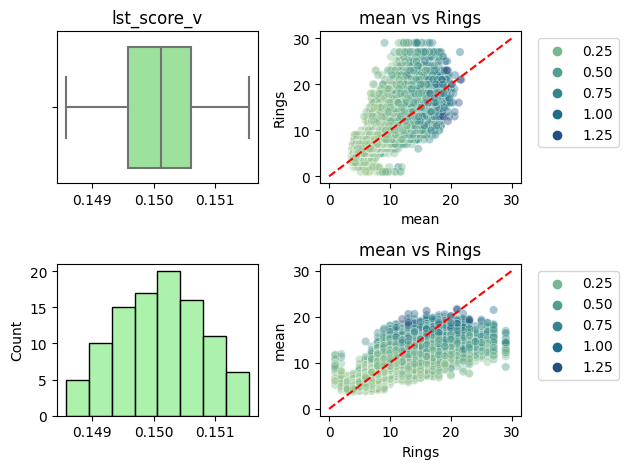

100it [01:41,  1.01s/it]


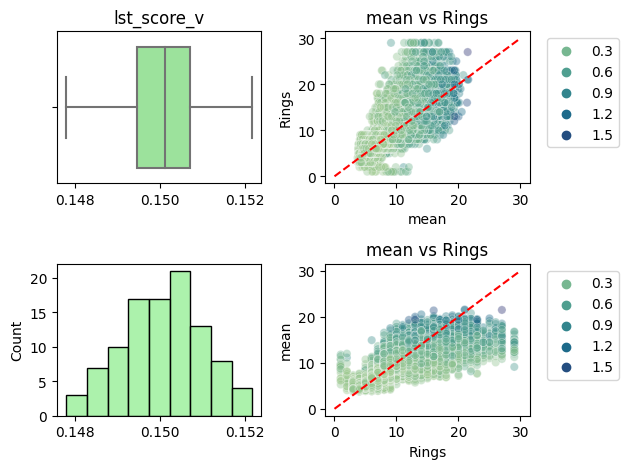

100it [01:39,  1.00it/s]


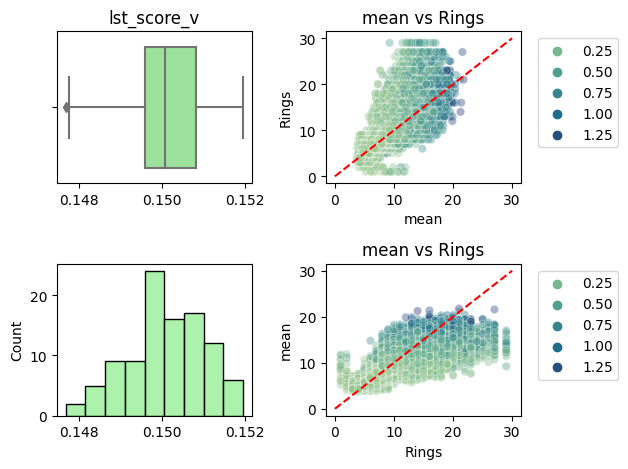

100it [01:45,  1.05s/it]


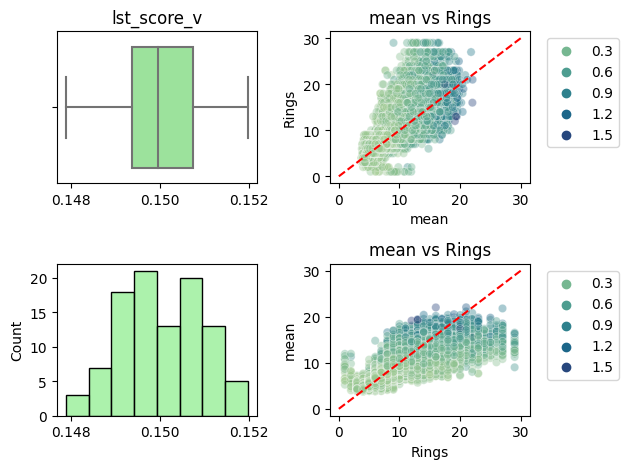

100it [01:47,  1.07s/it]


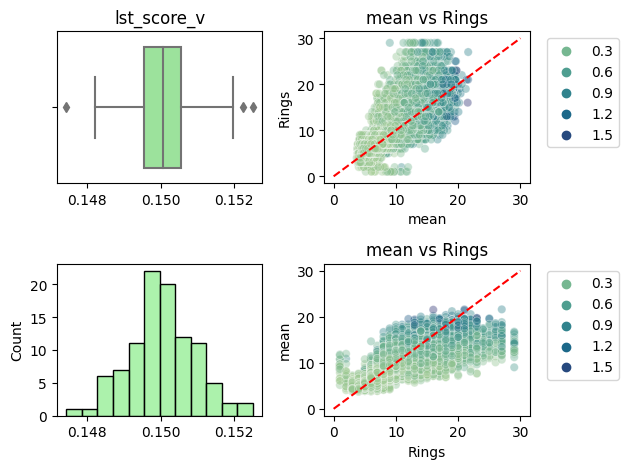

In [21]:
lst_cls = []
for i in range(5):
    clsData = ClsData00(seed=i)
    clsModel = ClsModelHistGradientBoostingRegressor(clsData)
    clsModel.optuna(n_trials=N_TRIALS,plot_history=False)
    clsModel.train_cv(n_splits=N_SPLITS,n_repeats=N_REPEATS,seed=i,plot=True)
    clsModel.predict_t()
    clsModelHGBR = clsModel
    lst_cls.append(clsModel)

In [22]:
df_ts = pd.DataFrame()
for i,cls in enumerate(lst_cls):
    df_t = cls.df_t_ps.add_suffix(f'{i}')
    df_ts = pd.concat([df_ts,df_t],axis='columns')
df_tm = df_ts.filter(like='mean')
df_tn = df_tm.mean(axis='columns').rename('Rings')
df_to = df_tn.reset_index(drop=False)
df_sub=df_to.rename(columns={'index':'id'})
df_sub

,id,Rings
0,90615,9.825601
1,90616,9.599445
2,90617,10.003604
3,90618,10.258167
4,90619,7.507952
...,...,...
60406,151021,6.321375
60407,151022,9.240375
60408,151023,11.874234
60409,151024,13.161449


In [23]:
df_sub.to_csv('df_submit.csv',index=None)